In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

layers = "../supervised_convnet/t_2.269/layer_by_layer/"
fine = "../supervised_convnet/t_2.269/x3x3/ising_temp2.269_correlated9x9from2187x2187.npy"
fine = np.load(fine)

In [2]:
fine.shape

(10000, 9, 9)

In [3]:
def sample_xy(data = fine, batch_size = 128):
    """
    Sample 3x6 rectangles from the fine grained data
    """
    num_samples, xdim, ydim = data.shape
    indices = np.random.randint(len(data), size = batch_size)
    arr = []
    for ind in indices:
        x, y = np.random.randint(xdim, size = 2)
        tmp = np.pad(data[ind], 6, mode = "wrap")[x:(x+3), y:(y+6)]
        arr.append(tmp)
    return np.stack(arr)
        
def get_xy():
    data = sample_xy()
    x = data[:, :3, :3].reshape(-1, 9)
    y = data[:, :3, 3:].reshape(-1, 9)
    return x, y


In [5]:
x, y = get_xy()
x[:10], y[:10]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]]), array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 1, 0, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0]]))

In [20]:
S=9
H=15
n_epoch = 2000
data_size = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.x_fc1 = nn.Linear(S, S)
        self.x_fc2 = nn.Linear(S, S)
        self.x_fc3 = nn.Linear(S, H)
        
        self.y_fc1 = nn.Linear(S, S)
        self.y_fc2 = nn.Linear(S, S)
        self.y_fc3 = nn.Linear(S, H)
        
        self.fc3 = nn.Linear(H, 1)
        
        
    def forward(self, x, y):
        inter_x = x + F.relu(self.x_fc1(x))
        inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = y + F.relu(self.y_fc1(y))
        inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    x_sample, y_sample=get_xy()
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 2000/2000 [00:31<00:00, 64.38it/s]


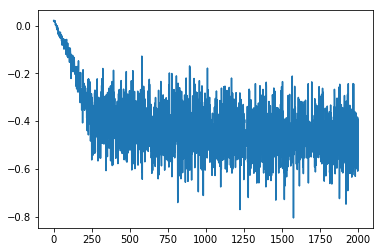

In [21]:
import matplotlib.pyplot as plt
plt.plot(plot_loss)
plt.show()

In [22]:
print(model.parameters)

for p in model.parameters():
    print(p)

<bound method Module.parameters of Net(
  (x_fc1): Linear(in_features=9, out_features=9, bias=True)
  (x_fc2): Linear(in_features=9, out_features=9, bias=True)
  (x_fc3): Linear(in_features=9, out_features=15, bias=True)
  (y_fc1): Linear(in_features=9, out_features=9, bias=True)
  (y_fc2): Linear(in_features=9, out_features=9, bias=True)
  (y_fc3): Linear(in_features=9, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=1, bias=True)
)>
Parameter containing:
tensor([[-0.2024,  0.3144, -0.1407, -0.0241, -0.2911,  0.2497, -0.2274, -0.0521,
          0.0135],
        [ 0.3172,  0.1078,  0.4976, -0.0796,  0.2526,  0.1883,  0.1112, -0.2759,
          0.1730],
        [-0.0341,  0.2580,  0.2995,  0.1361, -0.0381,  0.2025,  0.0446,  0.3215,
          0.0659],
        [ 0.0224, -0.1906,  0.4629,  0.1273,  0.2260,  0.4661, -0.1531,  0.0786,
          0.4210],
        [-0.0189,  0.1458, -0.0267,  0.3596, -0.2041, -0.2131,  0.3172,  0.0826,
          0.0392],
        [-0.16

In [25]:
ising27 = np.load("../supervised_convnet/t_2.269/layer_by_layer/ising27x27coarsegrained_temp2.269.npy")

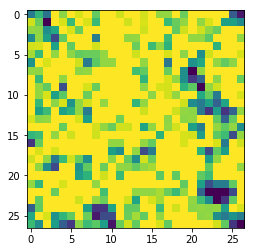

In [26]:
plt.imshow(ising27[0])

In [1]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
# for arr in tqdm(glob("../data_2187_1571810501/*")[2500:5000]):
#     z = np.load(arr)['arr_0']
#     x, y = np.random.randint(2187, size=2)
#     z = np.pad(z, pad_width=27, mode='wrap')[x:(x+27), y:(y+27)]
#     arrs.append(z)
# arrs = np.stack(arrs)

arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs.shape

(10001, 1, 27, 27)

## Took 9x9 image from 2187x2187 equilibrium Ising
Get 3x6 rectangles

Use MINE to compute the MI of fine-grained model

In [1]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
# for arr in tqdm(glob("../data_2187_1571810501/*")[2500:5000]):
#     z = np.load(arr)['arr_0']
#     x, y = np.random.randint(2187, size=2)
#     z = np.pad(z, pad_width=27, mode='wrap')[x:(x+27), y:(y+27)]
#     arrs.append(z)
# arrs = np.stack(arrs)

arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs.shape

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
S=9
H=15
n_epoch = 100
data_size = 20000
def pad_circular(x, pad):
    """
    function inspired by https://github.com/pytorch/pytorch/issues/3858
    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    x = torch.cat([x, x[0:pad]], dim=0)
    x = torch.cat([x, x[:, 0:pad]], dim=1)
    x = torch.cat([x[-2 * pad:-pad], x], dim=0)
    x = torch.cat([x[:, -2 * pad:-pad], x], dim=1)

    return x

class Net(nn.Module):
    def __init__(self, out_channels = 1, filter_size = 3):
        super(Net, self).__init__()
        
        self.x_fc1 = nn.Linear(S, S)
        self.x_fc2 = nn.Linear(S, S)
        self.x_fc3 = nn.Linear(S, H)
        
        self.y_fc1 = nn.Linear(S, S)
        self.y_fc2 = nn.Linear(S, S)
        self.y_fc3 = nn.Linear(S, H)
        
        self.fc3 = nn.Linear(H, 1)
        
        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        
        
    def MI_net(self, x, y):
        inter_x = x + F.relu(self.x_fc1(x))
        inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = y + F.relu(self.y_fc1(y))
        inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2  
    
    def forward(self, x):
        # coarse grain 27x27 model to get 9x9 model
        x = (self.conv1(x))
        
        rectangle = []
        # get a random 3x6 rectangle
        for data in x:
            i, j = np.random.randint(x.size()[2], size = 2) 
            rectangle.append( pad_circular(data[0], 6)[i:(i+3), j:(j+6)])
            

        rectangle = torch.stack(rectangle)
        # separate rectangle into 2 patches of shape 3x3 
        patch1 = rectangle[:, :3, :3].reshape(-1, 9)
        patch2 = rectangle[:, :3, 3:].reshape(-1, 9)
        patch2_shuffled = patch2[torch.randperm(patch2.shape[0])]
        
        # compute MI
        pred_xy = self.MI_net(patch1, patch2)
        pred_x_y = self.MI_net(patch1, patch2_shuffled)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        return -ret
        
class IsingDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, arrs):
        'Initialization'
        self.arrs = torch.Tensor(arrs)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.arrs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.arrs[index] 
    
# Generators
# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6}
training_set = IsingDataset(arrs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    for batch_id, x in enumerate(training_generator):
        loss = model(x)
        plot_loss.append(loss.data.numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()

        
        
        

100%|██████████| 100/100 [03:51<00:00,  2.31s/it]


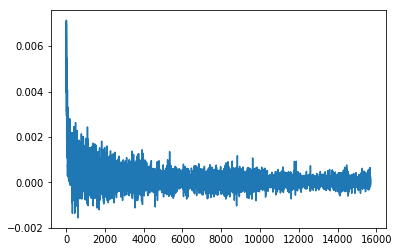

In [15]:
plt.plot(plot_loss)

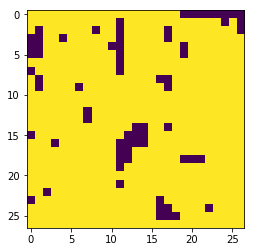

In [80]:
np.random.shuffle(arrs)
plt.imshow(arrs[0, 0])

In [65]:
x

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 0.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 1.,  ..., 1., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 0., 1., 1.]]],


        [[[0., 1., 1.,  ..., 1., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]],


        ...,


        [[[1., 1., 0.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1.

In [16]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-0.2183,  0.0446, -0.1543, -0.2001,  0.0173, -0.1787, -0.1593, -0.3256,
         -0.1779],
        [ 0.2136,  0.2964, -0.0557, -0.0617,  0.2429, -0.1353, -0.2834,  0.0016,
          0.1671],
        [-0.0634,  0.1111, -0.2247, -0.2405,  0.3307,  0.3318,  0.2806, -0.0792,
          0.2257],
        [ 0.1736, -0.3259, -0.2495, -0.3120, -0.1864, -0.2586, -0.1370, -0.2451,
          0.0600],
        [-0.2541, -0.3226, -0.1372,  0.2606,  0.1418,  0.1681,  0.0011,  0.0229,
         -0.0042],
        [-0.2612,  0.2640,  0.2153, -0.0742, -0.0288, -0.3304, -0.0844,  0.0261,
         -0.0217],
        [-0.2982, -0.0244,  0.2586, -0.1081,  0.1702, -0.1325,  0.1528, -0.1541,
         -0.1726],
        [ 0.2684, -0.2711, -0.0155,  0.1058, -0.3200, -0.0169, -0.2422,  0.1496,
         -0.2119],
        [ 0.2713,  0.0011,  0.1356, -0.0590,  0.1817,  0.3287, -0.1461, -0.1843,
          0.0801]], requires_grad=True)
Parameter containing:
tensor([ 0.3069, -0.2396,  0.2099, 

In [69]:
np.sum([-0.0069, -0.1340, -0.2858, 0.1158 , 0.0656])+0.2321

-0.013199999999999962

In [17]:
model_new = torch.load("./model1")


In [18]:
for p in model_new.parameters():
    print(p)

Parameter containing:
tensor([[-0.2416, -0.1384, -0.0750,  0.0696, -0.1495,  0.0446, -0.2089, -0.1212,
          0.3529],
        [ 0.0423,  0.0182, -0.1014,  0.2105,  0.1594, -0.1010, -0.2043,  0.2894,
         -0.1138],
        [-0.0507, -0.1224,  0.2920,  0.0892, -0.1562,  0.1920, -0.1611, -0.1079,
         -0.1617],
        [ 0.2255,  0.2059, -0.2575,  0.0580,  0.2410,  0.2314, -0.2205, -0.0277,
         -0.0512],
        [-0.0133, -0.2488, -0.0874,  0.1844, -0.0780,  0.0692,  0.2565,  0.1403,
          0.1287],
        [ 0.1161,  0.1599,  0.1824, -0.1020,  0.2033, -0.1107, -0.0732, -0.2342,
         -0.0682],
        [ 0.1511, -0.1561, -0.0006,  0.1638,  0.1103,  0.1276, -0.2214,  0.0425,
         -0.0461],
        [ 0.2223,  0.1070,  0.2554,  0.0338,  0.0118,  0.1134,  0.1501, -0.0868,
         -0.0097],
        [ 0.1882,  0.2096, -0.1455,  0.0891, -0.3372,  0.2274,  0.2028, -0.2311,
          0.0652]], requires_grad=True)
Parameter containing:
tensor([ 0.0055,  0.0650,  0.2860, 

## Took 9x9 image from 2187x2187 equilibrium Ising with a 3x3 filter to Coarse-grain to 3x3

Get 1x2 rectangles

Use MINE to compute the MI of fine-grained model


In [ ]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
# for arr in tqdm(glob("../data_2187_1571810501/*")[2500:5000]):
#     z = np.load(arr)['arr_0']
#     x, y = np.random.randint(2187, size=2)
#     z = np.pad(z, pad_width=27, mode='wrap')[x:(x+27), y:(y+27)]
#     arrs.append(z)
# arrs = np.stack(arrs)

arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs = np.pad(arrs, [(0, 0), (0, 0), (9, 9), (9, 9)], mode='wrap') 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
S=9
H=15
n_epoch = 100
data_size = 20000
def pad_circular(x, pad):
    """
    function inspired by https://github.com/pytorch/pytorch/issues/3858
    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    x = torch.cat([x, x[0:pad]], dim=0)
    x = torch.cat([x, x[:, 0:pad]], dim=1)
    x = torch.cat([x[-2 * pad:-pad], x], dim=0)
    x = torch.cat([x[:, -2 * pad:-pad], x], dim=1)

    return x

class Net(nn.Module):
    def __init__(self, out_channels = 1, filter_size = 3):
        super(Net, self).__init__()
        
        self.x_fc1 = nn.Linear(1, S)
        self.x_fc2 = nn.Linear(S, S)
        self.x_fc3 = nn.Linear(S, H)
        
        self.y_fc1 = nn.Linear(1, S)
        self.y_fc2 = nn.Linear(S, S)
        self.y_fc3 = nn.Linear(S, H)
        
        self.fc3 = nn.Linear(H, 1)
        
        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        
        
    def MI_net(self, x, y):
        inter_x = F.relu(self.x_fc1(x))
        inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = F.relu(self.y_fc1(y))
        inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2  
    
    def forward(self, x):
        # get 9x9 model from 27x27 data: random crop
        i, j = np.random.randint(9, size = 2) 
        x = x[:, :, i:(i+9),j:(j+9)]
        
        # coarse grain 9x9 model to get 3x3 model
        x = (self.conv1(x))
        
        
        rectangle = []
        # get a random 1x2 rectangle
        for data in x:
            i, j = np.random.randint(3, size = 2) 
            rectangle.append( pad_circular(data[0], 2)[i, j:(j+2)])
            

        rectangle = torch.stack(rectangle)
        # separate rectangle into 2 patches of shape 3x3 
        patch1 = rectangle[:, 0].reshape(-1, 1)
        patch2 = rectangle[:, 1].reshape(-1, 1)
        patch2_shuffled = patch2[torch.randperm(patch2.shape[0])]
        
        # compute MI
        pred_xy = self.MI_net(patch1, patch2)
        pred_x_y = self.MI_net(patch1, patch2_shuffled)
        ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        return -ret
        
class IsingDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, arrs):
        'Initialization'
        self.arrs = torch.Tensor(arrs)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.arrs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.arrs[index] 
    
# Generators
# Parameters
params = {'batch_size': 256*2,
          'shuffle': True,
          'num_workers': 6}
training_set = IsingDataset(arrs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    for batch_id, x in enumerate(training_generator):
        loss = model(x)
        plot_loss.append(loss.data.numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()

        
        
        

 18%|█▊        | 18/100 [01:15<05:44,  4.21s/it]

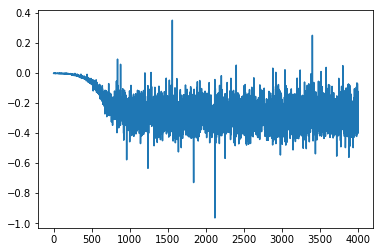

In [77]:
plt.plot(plot_loss)

In [79]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-0.6540],
        [-0.5533],
        [-0.6793],
        [ 0.4195],
        [ 0.8548],
        [-0.4211],
        [-0.3385],
        [-0.8258],
        [-0.9614]], requires_grad=True)
Parameter containing:
tensor([-0.2122,  0.8114, -0.3395, -0.3440,  0.5217,  0.4026, -0.4980, -0.1230,
         0.2377], requires_grad=True)
Parameter containing:
tensor([[-0.3367,  0.1492,  0.1795,  0.1639,  0.2649, -0.1195, -0.1380, -0.1987,
         -0.0603],
        [-0.1603, -0.0099, -0.0516, -0.2591, -0.0333, -0.0957, -0.2553,  0.2500,
         -0.2745],
        [ 0.2105, -0.1913, -0.1776,  0.1131, -0.1708,  0.0107, -0.3013,  0.1438,
         -0.2675],
        [ 0.2748,  0.1357, -0.1312, -0.3143,  0.2188, -0.3339,  0.3055,  0.1435,
          0.2665],
        [ 0.3128, -0.1590, -0.3159,  0.1602, -0.0722,  0.1636, -0.2494, -0.3329,
          0.0961],
        [-0.3098,  0.2042, -0.0654, -0.0881,  0.2716,  0.2125,  0.1114, -0.1945,
         -0.3072],
        [ 0.0612,  0.234

## 2 channels

In [5]:
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
arrs = []
# for arr in tqdm(glob("../data_2187_1571810501/*")[2500:5000]):
#     z = np.load(arr)['arr_0']
#     x, y = np.random.randint(2187, size=2)
#     z = np.pad(z, pad_width=27, mode='wrap')[x:(x+27), y:(y+27)]
#     arrs.append(z)
# arrs = np.stack(arrs)

arrs = np.load("./ising27x27from2187x2187.npy")[:, None, :, :]
arrs = np.pad(arrs, [(0, 0), (0, 0), (9, 9), (9, 9)], mode='wrap') 

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
S=9
H=15
n_epoch = 100
data_size = 20000
def pad_circular(x, pad):
    """
    function inspired by https://github.com/pytorch/pytorch/issues/3858
    :param x: shape [H, W]
    :param pad: int >= 0
    :return:
    """
    x = torch.cat([x, x[:, 0:pad, :]], dim=1)
    x = torch.cat([x, x[:, :, 0:pad]], dim=2)
    x = torch.cat([x[:, -2 * pad:-pad, :], x], dim=1)
    x = torch.cat([x[:, :, -2 * pad:-pad], x], dim=2)

    return x

class Net(nn.Module):
    def __init__(self, out_channels = 1, filter_size = 3):
        super(Net, self).__init__()
        self.first_channel_MI_net = [nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), 
                                nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), nn.Linear(H, 1)]
        self.second_channel_MI_net = [nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), 
                                 nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), nn.Linear(H, 1)]
        self.interaction_channel_MI_net = [nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), 
                                      nn.Linear(1, S), nn.Linear(S, S), nn.Linear(S, H), nn.Linear(H, 1)]

        
        self.conv1 = nn.Conv2d(1, out_channels, filter_size, padding=0, stride = filter_size)
        
        
    def MI_net(self, x, y, channel_MI_net):
        self.x_fc1, self.x_fc2, self.x_fc3, self.y_fc1, self.y_fc2, self.y_fc3, self.fc3 = channel_MI_net
        inter_x = F.relu(self.x_fc1(x))
        inter_x = inter_x + F.relu(self.x_fc2(inter_x))
        inter_x = self.x_fc3(inter_x)
        
        inter_y = F.relu(self.y_fc1(y))
        inter_y = inter_y + F.relu(self.y_fc2(inter_y))
        inter_y = self.y_fc3(inter_y)
        
        
        h1 = F.relu(inter_x + inter_y)
        h2 = self.fc3(h1)
        return h2  
    
    def compute_channel_MI(self, channel_rectangle, channel_MI_net):
        # separate rectangle into 2 patches of shape 3x3 
        patch1 = channel_rectangle[:, 0].reshape(-1, 1)
        patch2 = channel_rectangle[:, 1].reshape(-1, 1)
        patch2_shuffled = patch2[torch.randperm(patch2.shape[0])]
        
        # compute MI of channel
        pred_xy = self.MI_net(patch1, patch2, channel_MI_net)
        pred_x_y = self.MI_net(patch1, patch2_shuffled, channel_MI_net)
        MI = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        return MI
    
    def forward(self, x):
        # get 9x9 model from 27x27 data: random crop
        i, j = np.random.randint(9, size = 2) 
        x = x[:, :, i:(i+9),j:(j+9)]
        
        # coarse grain 9x9 model to get 3x3 model
        x = (self.conv1(x))
        channel0_rectangle = []
        channel1_rectangle = []
        # get a random 1x2 rectangle
        for data in x:
            i, j = np.random.randint(3, size = 2) 
            channels = pad_circular(data, 2)[:, i, j:(j+2)]
            channel0_rectangle.append(channels[0] )
            channel1_rectangle.append(channels[1] )
        channel0_rectangle = torch.stack(channel0_rectangle)
        channel1_rectangle = torch.stack(channel1_rectangle)
        first_channel_MI = self.compute_channel_MI(channel0_rectangle, self.first_channel_MI_net)
        second_channel_MI = self.compute_channel_MI(channel1_rectangle, self.second_channel_MI_net)
#         v = torch.cat([channel0_rectangle[:, 0].reshape(-1, 1), channel1_rectangle[:, 0].reshape(-1, 1)], dim=1)
#         print(v.shape)
#         interaction_rectangle = torch.cat([channel0_rectangle[:, 0], channel1_rectangle[:, 0]], dim=1)
#         print(channel0_rectangle[:, 0])
#         print(channel1_rectangle[:, 0])
#         print(interaction_rectangle)
#         first_second_channel_MI = self.compute_channel_MI(interaction_rectangle, interaction_channel_MI_net)
        
        
        
        return -(first_channel_MI + second_channel_MI)
        
class IsingDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, arrs):
        'Initialization'
        self.arrs = torch.Tensor(arrs)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.arrs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        return self.arrs[index] 
    
# Generators
# Parameters
params = {'batch_size': 256*4,
          'shuffle': True,
          'num_workers': 6}
training_set = IsingDataset(arrs)
training_generator = torch.utils.data.DataLoader(training_set, **params)

model = Net(out_channels = 2)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    
    for batch_id, x in enumerate(training_generator):
        loss = model(x)
        plot_loss.append(loss.data.numpy())
        model.zero_grad()
        loss.backward()
        optimizer.step()
    print("No interaction MI: Loss", loss.data.numpy())

        
        
        

  1%|          | 1/100 [00:08<14:14,  8.63s/it]

No interaction MI: Loss 0.0015777573


  2%|▏         | 2/100 [00:16<13:44,  8.42s/it]

No interaction MI: Loss 0.0011266284


  3%|▎         | 3/100 [00:24<13:23,  8.29s/it]

No interaction MI: Loss 0.0015241783


  4%|▍         | 4/100 [00:32<13:13,  8.26s/it]

No interaction MI: Loss 0.0010597985


  5%|▌         | 5/100 [00:41<13:19,  8.41s/it]

No interaction MI: Loss 0.0011695474


  6%|▌         | 6/100 [00:49<12:55,  8.25s/it]

No interaction MI: Loss 0.0015885122


  7%|▋         | 7/100 [00:57<12:40,  8.18s/it]

No interaction MI: Loss 0.0016809497


  8%|▊         | 8/100 [01:05<12:27,  8.13s/it]

No interaction MI: Loss 0.0016332753


  9%|▉         | 9/100 [01:13<12:14,  8.07s/it]

No interaction MI: Loss 0.0016189292


 10%|█         | 10/100 [01:21<12:01,  8.02s/it]

No interaction MI: Loss 0.000974942


 11%|█         | 11/100 [01:29<12:02,  8.11s/it]

No interaction MI: Loss 0.0016813334


 12%|█▏        | 12/100 [01:37<11:51,  8.09s/it]

No interaction MI: Loss 0.0014321562


 13%|█▎        | 13/100 [01:46<11:58,  8.26s/it]

No interaction MI: Loss 0.0010317359


 14%|█▍        | 14/100 [01:55<12:15,  8.55s/it]

No interaction MI: Loss 0.001021482


 15%|█▌        | 15/100 [02:04<12:21,  8.73s/it]

No interaction MI: Loss 0.0010697525


 16%|█▌        | 16/100 [02:13<12:28,  8.91s/it]

No interaction MI: Loss 0.0009996034


 17%|█▋        | 17/100 [02:23<12:30,  9.04s/it]

No interaction MI: Loss 0.001931563


 18%|█▊        | 18/100 [02:32<12:28,  9.12s/it]

No interaction MI: Loss 0.0009673927


 19%|█▉        | 19/100 [02:41<12:21,  9.15s/it]

No interaction MI: Loss 0.0008722581


 20%|██        | 20/100 [02:51<12:12,  9.16s/it]

No interaction MI: Loss 0.0015033968


 21%|██        | 21/100 [03:00<12:08,  9.22s/it]

No interaction MI: Loss 0.0018826313


 22%|██▏       | 22/100 [03:09<12:01,  9.25s/it]

No interaction MI: Loss 0.001702236


 23%|██▎       | 23/100 [03:19<11:55,  9.29s/it]

No interaction MI: Loss 0.0008808691


 24%|██▍       | 24/100 [03:28<11:41,  9.23s/it]

No interaction MI: Loss 0.0014981795


 25%|██▌       | 25/100 [03:37<11:33,  9.25s/it]

No interaction MI: Loss 0.0011151601


 26%|██▌       | 26/100 [03:46<11:24,  9.25s/it]

No interaction MI: Loss 0.0014994685


 27%|██▋       | 27/100 [03:55<11:12,  9.22s/it]

No interaction MI: Loss 0.0016303994


 28%|██▊       | 28/100 [04:05<11:04,  9.23s/it]

No interaction MI: Loss 0.0012019109


 29%|██▉       | 29/100 [04:14<10:57,  9.26s/it]

No interaction MI: Loss 0.00081690773


 30%|███       | 30/100 [04:23<10:53,  9.34s/it]

No interaction MI: Loss 0.0009142924


 31%|███       | 31/100 [04:33<10:41,  9.30s/it]

No interaction MI: Loss 0.0008808598


 32%|███▏      | 32/100 [04:42<10:30,  9.27s/it]

No interaction MI: Loss 0.0015492681


 33%|███▎      | 33/100 [04:51<10:26,  9.35s/it]

No interaction MI: Loss 0.0006835554


 34%|███▍      | 34/100 [05:01<10:15,  9.33s/it]

No interaction MI: Loss 0.0015430711


 35%|███▌      | 35/100 [05:10<10:05,  9.32s/it]

No interaction MI: Loss 0.0013779607


 36%|███▌      | 36/100 [05:19<09:55,  9.31s/it]

No interaction MI: Loss 0.0008797031


 37%|███▋      | 37/100 [05:29<09:44,  9.28s/it]

No interaction MI: Loss 0.0009291563


 38%|███▊      | 38/100 [05:38<09:40,  9.37s/it]

No interaction MI: Loss 0.001000328


 39%|███▉      | 39/100 [05:47<09:26,  9.29s/it]

No interaction MI: Loss 0.0008029267


 40%|████      | 40/100 [05:56<09:16,  9.27s/it]

No interaction MI: Loss 0.0009141918


 41%|████      | 41/100 [06:06<09:06,  9.26s/it]

No interaction MI: Loss 0.0014674645


 42%|████▏     | 42/100 [06:15<08:55,  9.23s/it]

No interaction MI: Loss 0.00090965815


 43%|████▎     | 43/100 [06:24<08:48,  9.28s/it]

No interaction MI: Loss 0.0013000127


 44%|████▍     | 44/100 [06:34<08:42,  9.33s/it]

No interaction MI: Loss 0.0010123886


 45%|████▌     | 45/100 [06:43<08:30,  9.27s/it]

No interaction MI: Loss 0.0005600881


 46%|████▌     | 46/100 [06:52<08:21,  9.29s/it]

No interaction MI: Loss 0.0010033436


 47%|████▋     | 47/100 [07:02<08:14,  9.33s/it]

No interaction MI: Loss 0.0009187348


 48%|████▊     | 48/100 [07:11<08:02,  9.27s/it]

No interaction MI: Loss 0.0007217992


 49%|████▉     | 49/100 [07:20<07:52,  9.26s/it]

No interaction MI: Loss 0.00084428117


 50%|█████     | 50/100 [07:29<07:45,  9.32s/it]

No interaction MI: Loss 0.0012327265


 51%|█████     | 51/100 [07:39<07:34,  9.28s/it]

No interaction MI: Loss 0.00075898133


 52%|█████▏    | 52/100 [07:48<07:25,  9.28s/it]

No interaction MI: Loss 0.00091532804


 53%|█████▎    | 53/100 [07:57<07:15,  9.26s/it]

No interaction MI: Loss 0.0012499113


 54%|█████▍    | 54/100 [08:06<07:06,  9.28s/it]

No interaction MI: Loss 0.0011884831


 55%|█████▌    | 55/100 [08:16<06:55,  9.23s/it]

No interaction MI: Loss 0.0007104557


 56%|█████▌    | 56/100 [08:25<06:46,  9.25s/it]

No interaction MI: Loss 0.0008182619


 57%|█████▋    | 57/100 [08:34<06:39,  9.28s/it]

No interaction MI: Loss 0.00088130124


 58%|█████▊    | 58/100 [08:43<06:28,  9.25s/it]

No interaction MI: Loss 0.00095279515


 59%|█████▉    | 59/100 [08:53<06:19,  9.25s/it]

No interaction MI: Loss 0.0012682527


 60%|██████    | 60/100 [09:02<06:12,  9.31s/it]

No interaction MI: Loss 0.0006467905


 61%|██████    | 61/100 [09:11<06:00,  9.25s/it]

No interaction MI: Loss 0.0008542724


 62%|██████▏   | 62/100 [09:20<05:52,  9.27s/it]

No interaction MI: Loss 0.0008967221


 63%|██████▎   | 63/100 [09:30<05:44,  9.32s/it]

No interaction MI: Loss 0.0012221206


 64%|██████▍   | 64/100 [09:39<05:33,  9.27s/it]

No interaction MI: Loss 0.00083648786


 65%|██████▌   | 65/100 [09:48<05:24,  9.26s/it]

No interaction MI: Loss 0.0009782072


 66%|██████▌   | 66/100 [09:58<05:15,  9.29s/it]

No interaction MI: Loss 0.00071375817


 67%|██████▋   | 67/100 [10:07<05:05,  9.27s/it]

No interaction MI: Loss 0.001056971


 68%|██████▊   | 68/100 [10:16<04:57,  9.30s/it]

No interaction MI: Loss 0.00071725994


 69%|██████▉   | 69/100 [10:25<04:47,  9.28s/it]

No interaction MI: Loss 0.0010700952


 70%|███████   | 70/100 [10:35<04:40,  9.34s/it]

No interaction MI: Loss 0.0011492968


 71%|███████   | 71/100 [10:44<04:28,  9.26s/it]

No interaction MI: Loss 0.0004730206


 72%|███████▏  | 72/100 [10:53<04:18,  9.22s/it]

No interaction MI: Loss 0.0006664526


 73%|███████▎  | 73/100 [11:02<04:09,  9.26s/it]

No interaction MI: Loss 0.0006780457


 74%|███████▍  | 74/100 [11:12<04:00,  9.23s/it]

No interaction MI: Loss 0.0007652845


 75%|███████▌  | 75/100 [11:21<03:51,  9.25s/it]

No interaction MI: Loss 0.00090928935


 76%|███████▌  | 76/100 [11:31<03:44,  9.35s/it]

No interaction MI: Loss 0.0012036245


 77%|███████▋  | 77/100 [11:40<03:36,  9.41s/it]

No interaction MI: Loss 0.00093575753


 78%|███████▊  | 78/100 [11:49<03:25,  9.33s/it]

No interaction MI: Loss 0.00084299967


 79%|███████▉  | 79/100 [11:58<03:14,  9.28s/it]

No interaction MI: Loss 0.0012761243


 80%|████████  | 80/100 [12:08<03:06,  9.32s/it]

No interaction MI: Loss 0.0015273821


 81%|████████  | 81/100 [12:17<02:56,  9.31s/it]

No interaction MI: Loss 0.00066546723


 82%|████████▏ | 82/100 [12:26<02:47,  9.30s/it]

No interaction MI: Loss 0.00062205456


 83%|████████▎ | 83/100 [12:36<02:37,  9.25s/it]

No interaction MI: Loss 0.0008448381


 84%|████████▍ | 84/100 [12:45<02:27,  9.23s/it]

No interaction MI: Loss 0.0006670449


 85%|████████▌ | 85/100 [12:54<02:18,  9.21s/it]

No interaction MI: Loss 0.00056129135


 86%|████████▌ | 86/100 [13:03<02:09,  9.24s/it]

No interaction MI: Loss 0.0008078478


 87%|████████▋ | 87/100 [13:12<01:59,  9.22s/it]

No interaction MI: Loss 0.0012504961


 88%|████████▊ | 88/100 [13:22<01:50,  9.25s/it]

No interaction MI: Loss 0.0012835786


 89%|████████▉ | 89/100 [13:31<01:42,  9.28s/it]

No interaction MI: Loss 0.00062575005


 90%|█████████ | 90/100 [13:41<01:33,  9.35s/it]

No interaction MI: Loss 0.00053877383


 91%|█████████ | 91/100 [13:50<01:24,  9.35s/it]

No interaction MI: Loss 0.00091586076


 92%|█████████▏| 92/100 [13:59<01:14,  9.32s/it]

No interaction MI: Loss 0.0011179298


 93%|█████████▎| 93/100 [14:08<01:05,  9.31s/it]

No interaction MI: Loss 0.00071695074


 94%|█████████▍| 94/100 [14:18<00:55,  9.33s/it]

No interaction MI: Loss 0.000880491


 95%|█████████▌| 95/100 [14:27<00:46,  9.31s/it]

No interaction MI: Loss 0.00071799755


 96%|█████████▌| 96/100 [14:36<00:37,  9.29s/it]

No interaction MI: Loss 0.00078080967


 97%|█████████▋| 97/100 [14:46<00:28,  9.34s/it]

No interaction MI: Loss 0.0005612541


 98%|█████████▊| 98/100 [14:55<00:18,  9.31s/it]

No interaction MI: Loss 0.0011970364


 99%|█████████▉| 99/100 [15:04<00:09,  9.32s/it]

No interaction MI: Loss 0.0010131188


100%|██████████| 100/100 [15:14<00:00,  9.14s/it]

No interaction MI: Loss 0.00062070414


In [6]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[[[ 0.3215,  0.1172, -0.1963],
          [-0.0865,  0.2060,  0.2958],
          [-0.2056, -0.0784, -0.2051]]],


        [[[ 0.0890, -0.1398,  0.2501],
          [ 0.1001, -0.1484,  0.2637],
          [-0.2974, -0.2091, -0.0277]]]], requires_grad=True)
Parameter containing:
tensor([0.2827, 0.1990], requires_grad=True)
Parameter containing:
tensor([[ 0.4847],
        [ 0.6630],
        [-0.5311],
        [ 0.2933],
        [ 0.6452],
        [ 0.9871],
        [-0.5071],
        [-0.6231],
        [-0.6702]], requires_grad=True)
Parameter containing:
tensor([ 0.6844,  0.3854,  0.4396,  0.1202, -0.1184, -0.3358,  0.2033, -0.1880,
         0.2205], requires_grad=True)
Parameter containing:
tensor([[ 0.1848, -0.0814,  0.1124, -0.1723,  0.2275,  0.0995, -0.2310,  0.0296,
         -0.2039],
        [ 0.0424,  0.2221,  0.0723, -0.1759,  0.2035, -0.3062, -0.0058, -0.2853,
          0.0090],
        [-0.2294, -0.0172, -0.1518, -0.1226, -0.2163,  0.0220,  0.2555,  0

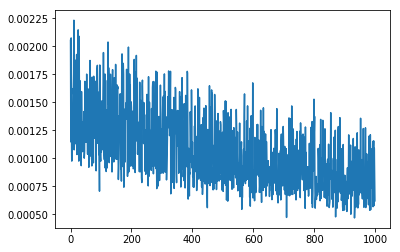

In [7]:
plt.plot(plot_loss)